In [1]:
import numpy as np
import matplotlib.pyplot as plt

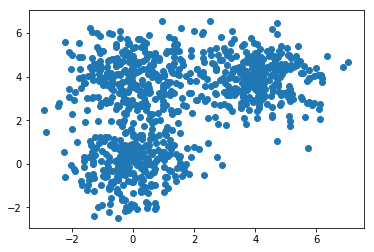

In [2]:
#creating random vectors of 3 distributions
D = 2 #dims
s = 4 #position of the distribution
mu1 = np.array([0,0]) #dist 1
mu2 = np.array([s,s]) #dist 2
mu3 = np.array([0,s]) #dist 3

N = 900
X = np.zeros((N, D))
X[:300, :] = np.random.randn(300, D) + mu1
X[300:600, :] = np.random.randn(300, D) + mu2
X[600:, :] = np.random.randn(300, D) + mu3

plt.scatter(X[:,0], X[:,1])
plt.show()

In [3]:
def d(u, v): #calculate euclidean distance
    diff = u - v
    return diff.dot(diff) #|| u - v ||^2

def cost(X, R, M):
    cost = 0
    for k in range(len(M)):
        for n in range(len(X)):
            cost += R[n,k]*d(M[k], X[n])
    return cost

def plot_k_means(X, K, max_iter=20, beta=1.0, debug=False): # X = data, K = number of clusters
    random_colors = np.random.random((K, 3))
    
    N, D = X.shape #N = number of vectors, D = number of dimensions
    M = np.zeros((K, D)) #means matrix
    R = np.zeros((N, K)) #responsibility matrix
    
    for k in range(K):
        M[k] = X[np.random.choice(N)] #initializing of random points of X
        
    costs = np.zeros(max_iter)
    for i in range(max_iter):
        
        if debug:
            colors = R.dot(random_colors)
            plt.scatter(X[:,0], X[:,1], c=colors)
            plt.scatter(M[:,0], M[:,1], color = 'red')
            plt.title(i)
            plt.show()
        
        #Calculate the probability of each vector n belongs to vector m
        for k in range(K): #for each cluster
            for n in range(N): #for each point                
                distance = d(M[k], X[n])
                numerator = np.exp(-beta*distance) #this will grant an non-linear weight for the distance. -beta will invert the result.
                denominator = np.sum(np.exp(-beta*d(M[j], X[n])) for j in range(K)) #sum the weights of all vectors m given vector n
                R[n,k] = numerator / denominator #generate probability of vector n belongs to vector m
        
        #recalculate a weighted mean of each centroid
        for k in range(K):
            sums = np.zeros(2)
            for n in range(N):
                for dimens in range(D):
                    sums[dimens] += R[n,k] * X[n,dimens] 
            numerator = sums
            sums_den = 0
            for n in range(N):
                sums_den += R[n,k]
            denominator = sums_den
            M[k] = numerator / denominator
#             M[k] = R[:,k].dot(X) / R[:,k].sum()  #can be resumed to this line
        costs[i] = cost(X, R, M)
        if i > 0:
            if np.abs(costs[i] - costs[i-1]) < 0.1:
                break
    
    plt.plot(costs)
    plt.title("Costs")
    plt.show()
    
    colors = R.dot(random_colors)
    plt.scatter(X[:,0], X[:,1], c=colors)
    plt.show()

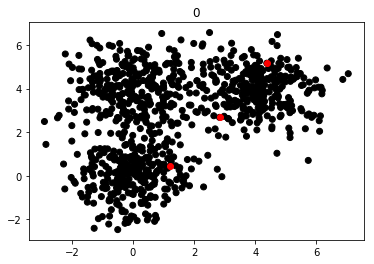

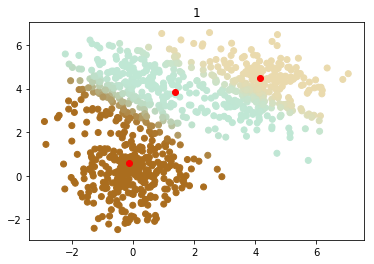

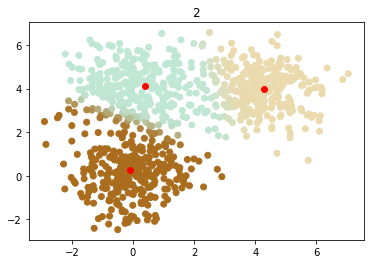

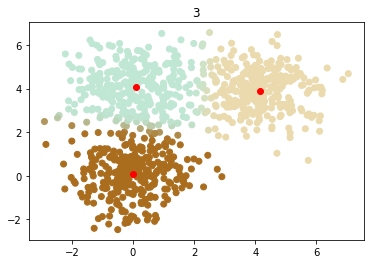

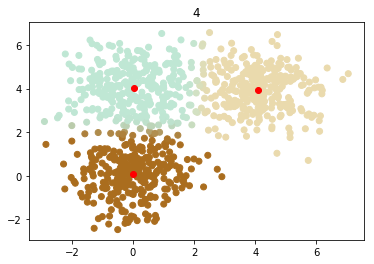

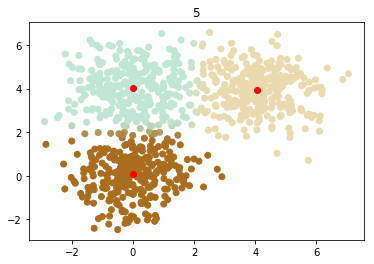

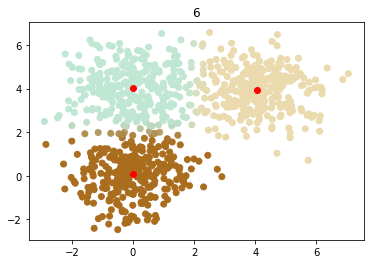

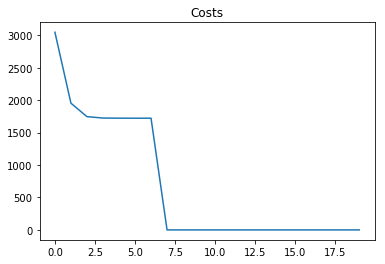

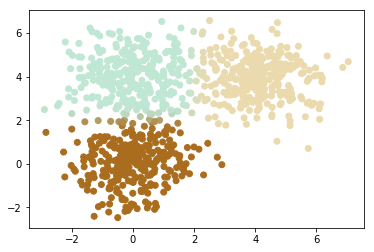

In [4]:
K = 3
plot_k_means(X, K, max_iter=20,beta=1, debug=True)

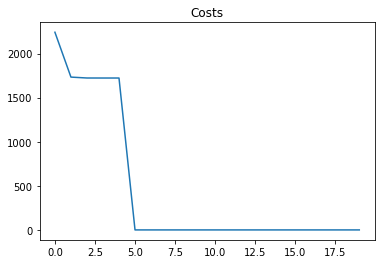

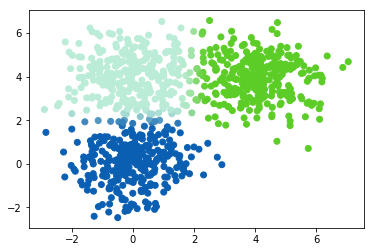

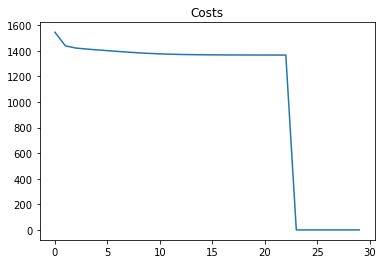

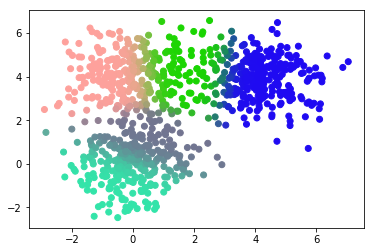

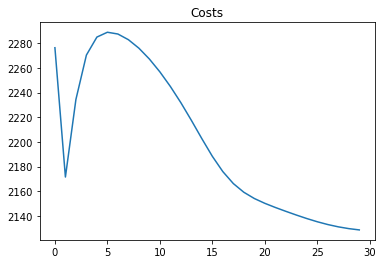

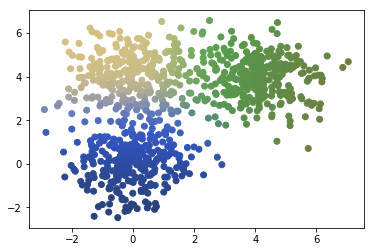

In [5]:
K = 3
plot_k_means(X, K)

K = 5
plot_k_means(X, K, max_iter=30)

K = 5
plot_k_means(X, K, max_iter=30, beta=0.3)

## Scenarios that kmeans fails ##

In [6]:
def donut():
    N = 1000
    D = 2
    
    R_inner = 5.0
    R_outer = 10.0
    
    R1 = np.random.randn(N//2) + R_inner
    theta = 2*np.pi*np.random.random(N//2)
    X_inner = np.concatenate([[R1 * np.cos(theta)], [R1*np.sin(theta)]]).T
    
    R2 = np.random.randn(N//2) + R_outer
    X_outer = np.concatenate([[R2 * np.cos(theta)], [R2*np.sin(theta)]]).T
    
    X = np.concatenate([X_inner, X_outer])
    return X

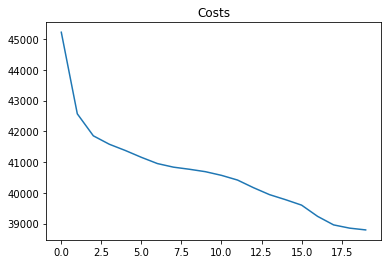

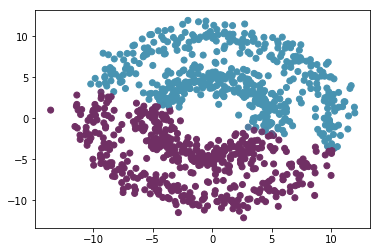

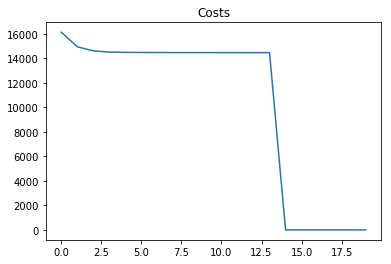

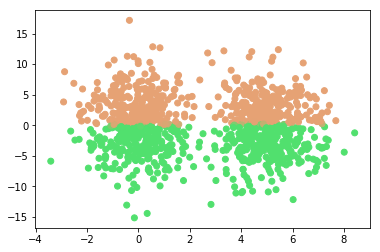

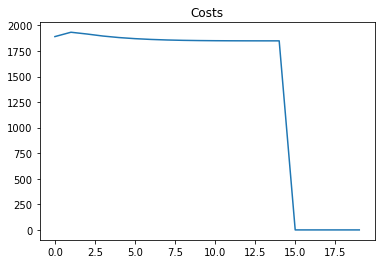

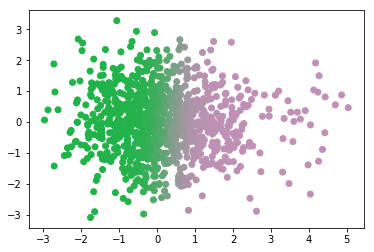

In [7]:
X = donut()
plot_k_means(X,2)


#elongated
X = np.zeros((1000, 2))
X[:500,:] = np.random.multivariate_normal([0,0], [[1,0], [0,20]], 500)
X[500:,:] = np.random.multivariate_normal([5,0], [[1,0], [0,20]], 500)
plot_k_means(X,2)


#poor clusterization with different densities
X = np.zeros((1000, 2))
X[:950, :] = np.array([0,0]) + np.random.randn(950, 2)
X[950:,:] = np.array([3,0]) + np.random.randn(50, 2)
plot_k_means(X,2)

## kmeans with MNIST ##

In [8]:
import pandas as pd

def get_data(limit=None):
    df = pd.read_csv('./train.csv')
    data = df.as_matrix()
    np.random.shuffle(data)
    X = data[:, 1:] / 255.0 # data is from 0..255
    Y = data[:, 0]
    if limit is not None:
        X, Y = X[:limit], Y[:limit]
    return X, Y

def purity(Y, R):
    # maximum purity is 1, higher is better
    N, K = R.shape
    p = 0
    for k in range(K):
        best_target = -1
        max_intersection = 0
        for j in range(K):
            intersection = R[Y==j, k].sum()
            if intersection > max_intersection:
                max_intersection = intersection
                best_target = j
        p += max_intersection
    
    return p/N


def DBI(X, M, R):
    #lower is better
    #N, D = X.shape
    
    K, D = M.shape
    
    #get sigmas first
    sigma = np.zeros(K)
    for k in range(K):
        diffs = X - M[k] #should be NxD
        # assert(len(diffs.shape) == 2 and diffs.shape[1] == D)
        squared_distances = (diffs * diffs).sum(axis=1)
        #assert(len(squared_distances.shape) == 1 and len(squared_distances) != )
        weighted_squared_distances = R[:,k]*squared_distances
        sigma[k] = np.sqrt(weighted_squared_distances).mean()
        
    
    #calculate Davies-Bouldin Index
    dbi = 0
    for k in range(K):
        max_ratio = 0
        for j in range(K):
            if k != j:
                numerator = sigma[k] + sigma[j]
                denominator = np.linalg.norm(M[k] - M[j])
                ratio = numerator / denominator
                if ratio > max_ratio:
                    max_ratio = ratio
        dbi += max_ratio
    return dbi / K

In [9]:
def d(u, v):
    diff = u - v
    return diff.dot(diff)


def cost(X, R, M):
    cost = 0
    for k in range(len(M)):
        # method 1
        # for n in range(len(X)):
        #     cost += R[n,k]*d(M[k], X[n])

        # method 2
        diff = X - M[k]
        sq_distances = (diff * diff).sum(axis=1)
        cost += (R[:,k] * sq_distances).sum()
    return cost


def plot_k_means_adapted(X, K, max_iter=20, beta=1.0, show_plots=True):
    N, D = X.shape
    M = np.zeros((K, D))
    # R = np.zeros((N, K))
    exponents = np.empty((N, K))

    # initialize M to random
    for k in range(K):
        M[k] = X[np.random.choice(N)]

    costs = np.zeros(max_iter)
    for i in range(max_iter):
        # step 1: determine assignments / resposibilities
        # is this inefficient?
        for k in range(K):
            for n in range(N):
                # R[n,k] = np.exp(-beta*d(M[k], X[n])) / np.sum( np.exp(-beta*d(M[j], X[n])) for j in range(K) )
                exponents[n,k] = np.exp(-beta*d(M[k], X[n]))

        R = exponents / exponents.sum(axis=1, keepdims=True)
        # assert(np.abs(R - R2).sum() < 1e-10)

        # step 2: recalculate means
        for k in range(K):
            M[k] = R[:,k].dot(X) / R[:,k].sum()

        costs[i] = cost(X, R, M)
        if i > 0:
            if np.abs(costs[i] - costs[i-1]) < 1e-5:
                break

    if show_plots:
        plt.plot(costs)
        plt.title("Costs")
        plt.show()

        random_colors = np.random.random((K, 3))
        colors = R.dot(random_colors)
        plt.scatter(X[:,0], X[:,1], c=colors)
        plt.show()

    return M, R

def get_simple_data():
    # assume 3 means
    D = 2 # so we can visualize it more easily
    s = 4 # separation so we can control how far apart the means are
    mu1 = np.array([0, 0])
    mu2 = np.array([s, s])
    mu3 = np.array([0, s])

    N = 900 # number of samples
    X = np.zeros((N, D))
    X[:300, :] = np.random.randn(300, D) + mu1
    X[300:600, :] = np.random.randn(300, D) + mu2
    X[600:, :] = np.random.randn(300, D) + mu3
    return X

Number of data points: 1000


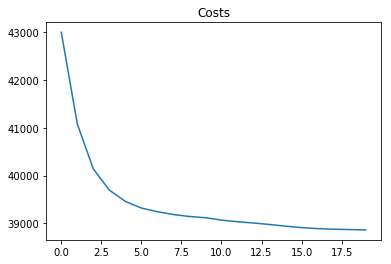

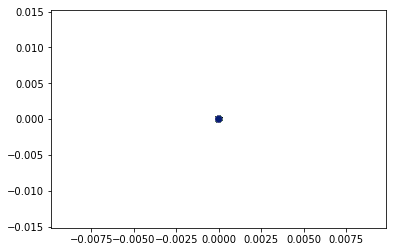

purity: 0.55534128516543
DBI: 0.3321841728513014


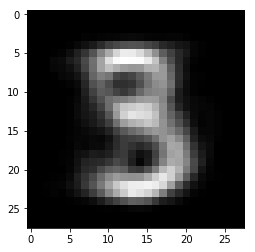

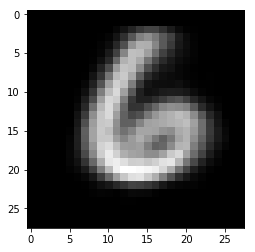

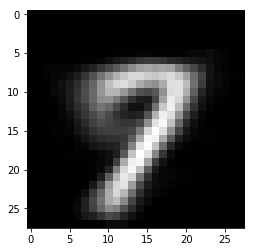

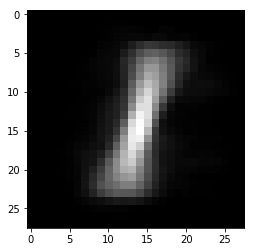

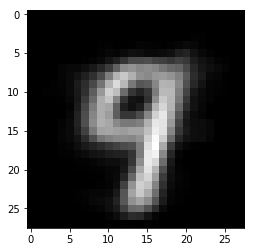

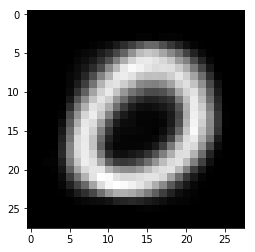

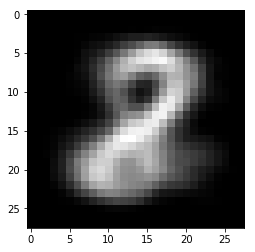

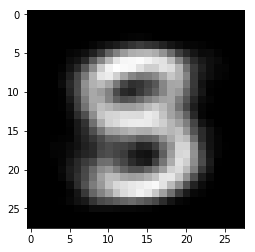

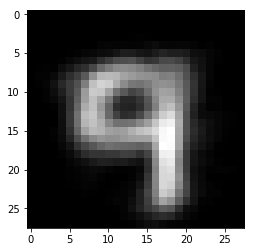

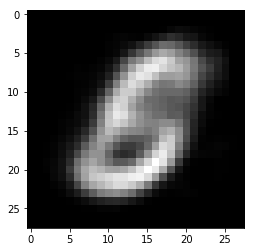

In [10]:
X, Y = get_data(1000)

print("Number of data points:", len(Y))
M, R = plot_k_means_adapted(X, len(set(Y)))

print("purity:", purity(Y, R))
print("DBI:", DBI(X, M, R))

# plot the mean images
# they should look like digits
for k in range(len(M)):
    im = M[k].reshape(28, 28)
    plt.imshow(im, cmap='gray')
    plt.show()
        

## A way of choosing value of K ##

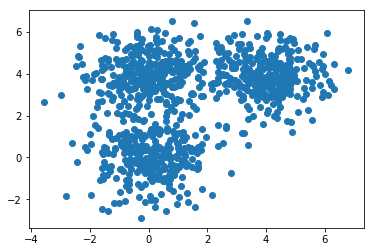

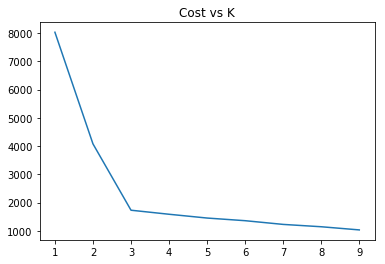

In [11]:
X = get_simple_data()

plt.scatter(X[:,0], X[:,1])
plt.show()

costs = np.empty(10)
costs[0] = None
for k in range(1, 10):
    M, R = plot_k_means_adapted(X, k, show_plots=False)
    c = cost(X, R, M)
    costs[k] = c

plt.plot(costs)
plt.title("Cost vs K")
plt.show()

Cost will naturally be 0 when K = N, so it is discarded. We can notice a great drop at 3, so 3 is an ideal number of K.

## Using K-means with text - a NLP approach ##
This step uses some text pre-processing techniques and a tf-ids model for the sentences vectorization.

In [12]:
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, LocallyLinearEmbedding as LLE
from sklearn.feature_extraction.text import TfidfTransformer
wordnet_lemmatizer = WordNetLemmatizer()

def my_tokenizer(s):
	s = s.lower() # downcase
	tokens = nltk.tokenize.word_tokenize(s) # split string into words (tokens)
	tokens = [t for t in tokens if len(t) > 2] # remove short words, they're probably not useful
	tokens = [wordnet_lemmatizer.lemmatize(t) for t in tokens] # put words into base form
	tokens = [t for t in tokens if t not in stopwords] # remove stopwords
	tokens = [t for t in tokens if not any(c.isdigit() for c in t)] # remove any digits, i.e. "3rd edition"
	return tokens

def tokens_to_vector(tokens):
	x = np.zeros(len(word_index_map))
	for t in tokens:
		i = word_index_map[t]
		x[i] += 1
	return x

def d(u, v):
	diff = u - v
	return diff.dot(diff)

def cost(X, R, M):
	cost = 0
	for k in range(len(M)):
		# method 1
		# for n in range(len(X)):
		#     cost += R[n,k]*d(M[k], X[n])

		# method 2
		diff = X - M[k]
		sq_distances = (diff * diff).sum(axis=1)
		cost += (R[:,k] * sq_distances).sum()
	return cost

def plot_k_means(X, K, index_word_map, max_iter=20, beta=1.0, show_plots=True):
	N, D = X.shape
	M = np.zeros((K, D))
	R = np.zeros((N, K))
	exponents = np.empty((N, K))

	# initialize M to random
	for k in range(K):
		M[k] = X[np.random.choice(N)]

	costs = np.zeros(max_iter)
	for i in range(max_iter):
		# step 1: determine assignments / resposibilities
		# is this inefficient?
		for k in range(K):
			for n in range(N):
				# R[n,k] = np.exp(-beta*d(M[k], X[n])) / np.sum( np.exp(-beta*d(M[j], X[n])) for j in range(K) )
				exponents[n,k] = np.exp(-beta*d(M[k], X[n]))

		R = exponents / exponents.sum(axis=1, keepdims=True)

		# step 2: recalculate means
		for k in range(K):
			M[k] = R[:,k].dot(X) / R[:,k].sum()

		costs[i] = cost(X, R, M)
		if i > 0:
			if np.abs(costs[i] - costs[i-1]) < 10e-5:
				break

	if show_plots:
		# plt.plot(costs)
		# plt.title("Costs")
		# plt.show()

		random_colors = np.random.random((K, 3))
		colors = R.dot(random_colors)
		plt.figure(figsize=(80.0, 80.0))
		plt.scatter(X[:,0], X[:,1], s=300, alpha=0.9, c=colors)
		annotate1(X, index_word_map)
		# plt.show()
		plt.savefig("test.png")


	# print out the clusters
	hard_responsibilities = np.argmax(R, axis=1) # is an N-size array of cluster identities
	# let's "reverse" the order so it's cluster identity -> word index
	cluster2word = {}
	for i in range(len(hard_responsibilities)):
		word = index_word_map[i]
		cluster = hard_responsibilities[i]
		if cluster not in cluster2word:
			cluster2word[cluster] = []
		cluster2word[cluster].append(word)

	# print out the words grouped by cluster
	for cluster, wordlist in cluster2word.items():
		print("cluster", cluster, "->", wordlist)

	return M, R

def annotate1(X, index_word_map, eps=0.1):
	N, D = X.shape
	placed = np.empty((N, D))
	for i in range(N):
		x, y = X[i]

		# if x, y is too close to something already plotted, move it
		close = []

		x, y = X[i]
		for retry in range(3):
			for j in range(i):
				diff = np.array([x, y]) - placed[j]

				# if something is close, append it to the close list
				if diff.dot(diff) < eps:
					close.append(placed[j])

			if close:
				# then the close list is not empty
				x += (np.random.randn() + 0.5) * (1 if np.random.rand() < 0.5 else -1)
				y += (np.random.randn() + 0.5) * (1 if np.random.rand() < 0.5 else -1)
				close = [] # so we can start again with an empty list
			else:
				# nothing close, let's break
				break

		placed[i] = (x, y)

		plt.annotate(
			s=index_word_map[i],
			xy=(X[i,0], X[i,1]),
			xytext=(x, y),
			arrowprops={
			'arrowstyle' : '->',
			'color' : 'black',
			}
		)

In [13]:
titles = [line.rstrip() for line in open('./all_book_titles.txt')]

# copy tokenizer from sentiment example
stopwords = set(w.rstrip() for w in open('./stopwords.txt'))
# add more stopwords specific to this problem
stopwords = stopwords.union({
	'introduction', 'edition', 'series', 'application',
	'approach', 'card', 'access', 'package', 'plus', 'etext',
	'brief', 'vol', 'fundamental', 'guide', 'essential', 'printed',
	'third', 'second', 'fourth', })

# create a word-to-index map so that we can create our word-frequency vectors later
# let's also save the tokenized versions so we don't have to tokenize again later
word_index_map = {}
current_index = 0
all_tokens = []
all_titles = []
index_word_map = []
print("num titles:", len(titles))
print("first title:", titles[0])
for title in titles:
	try:
		title = title.encode('ascii', 'ignore') # this will throw exception if bad characters
		title = title.decode('utf-8')
		all_titles.append(title)
		tokens = my_tokenizer(title)
		all_tokens.append(tokens)
		for token in tokens:
			if token not in word_index_map:
				word_index_map[token] = current_index
				current_index += 1
				index_word_map.append(token)
	except Exception as e:
		print(e)

# now let's create our input matrices - just indicator variables for this example - works better than proportions
N = len(all_tokens)
D = len(word_index_map)
X = np.zeros((D, N)) # terms will go along rows, documents along columns
i = 0
for tokens in all_tokens:
	X[:,i] = tokens_to_vector(tokens)
	i += 1

print("vocab size:", current_index)

transformer = TfidfTransformer()
X = transformer.fit_transform(X).toarray()

reducer = TSNE()
Z = reducer.fit_transform(X)

num titles: 2373
first title: Philosophy of Sex and Love A Reader
vocab size: 2070


C:\Users\Denis\AppData\Local\conda\conda\envs\tensorflow_env_gpu\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [14]:
plot_k_means(Z[:,:2], current_index//10, index_word_map, show_plots=True)

C:\Users\Denis\AppData\Local\conda\conda\envs\tensorflow_env_gpu\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Denis\AppData\Local\conda\conda\envs\tensorflow_env_gpu\lib\site-packages\matplotlib\colors.py:233: RuntimeWarning: invalid value encountered in less
  if np.any((result < 0) | (result > 1)):
C:\Users\Denis\AppData\Local\conda\conda\envs\tensorflow_env_gpu\lib\site-packages\matplotlib\colors.py:233: RuntimeWarning: invalid value encountered in greater
  if np.any((result < 0) | (result > 1)):


cluster 0 -> ['philosophy', 'sex', 'love', 'reader', 'reading', 'judaism', 'christianity', 'islam', 'microprocessor', 'principle', 'bernhard', 'edouard', 'fernow', 'story', 'north', 'american', 'forestry', 'encyclopedia', 'buddhism', 'motorola', 'family', 'programming', 'interfacing', 'anthem', 'student', 'modern', 'era', 'read', 'literature', 'professor', 'lively', 'entertaining', 'line', 'mar', 'woman', 'venus', 'secret', 'improving', 'communication', 'lasting', 'intimacy', 'fulfillment', 'giving', 'receiving', 'passion', 'understanding', 'martian', 'religious', 'tradition', 'world', 'journey', 'africa', 'mesoamerica', 'america', 'hinduism', 'china', 'wisdom', 'sacred', 'text', 'religion', 'illustrated', 'soul', 'cultivating', 'life', 'act', 'thriving', 'chaos', 'handbook', 'management', 'revolution', 'blood', 'relative', 'wheelock', 'latin', 'choice', 'uncertainty', 'luck', 'thrive', 'despite', 'expanding', 'discourse', 'feminism', 'art', 'history', 'relativity', 'pure', 'applied', 

(array([[nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
